In [8]:
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from data_processing import load_and_preprocess_data


In [9]:
# Load the data
data_path = '../../data/raw/winequalityN.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_path, features_to_drop=['density'])
# the path to save the evaluation result images
eval_path = '../data/eval_result'

In [10]:
# Load models
models = {
    'Random Forest': load('../../models/random_forest_model.joblib'),
    'Decision Tree': load('../../models/pruned_decision_tree.joblib'),
    'SVM': load('../../models/svm.joblib')
}

In [11]:
# Calculate metrics for each model
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }

# Create bar plots for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# Print detailed results
print("\nDetailed Results:")
print("-" * 50)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")


Detailed Results:
--------------------------------------------------

Random Forest:
Accuracy: 0.952
Precision: 0.946
Recall: 0.952
F1: 0.943

Decision Tree:
Accuracy: 0.935
Precision: 0.916
Recall: 0.935
F1: 0.916

SVM:
Accuracy: 0.946
Precision: 0.934
Recall: 0.946
F1: 0.935


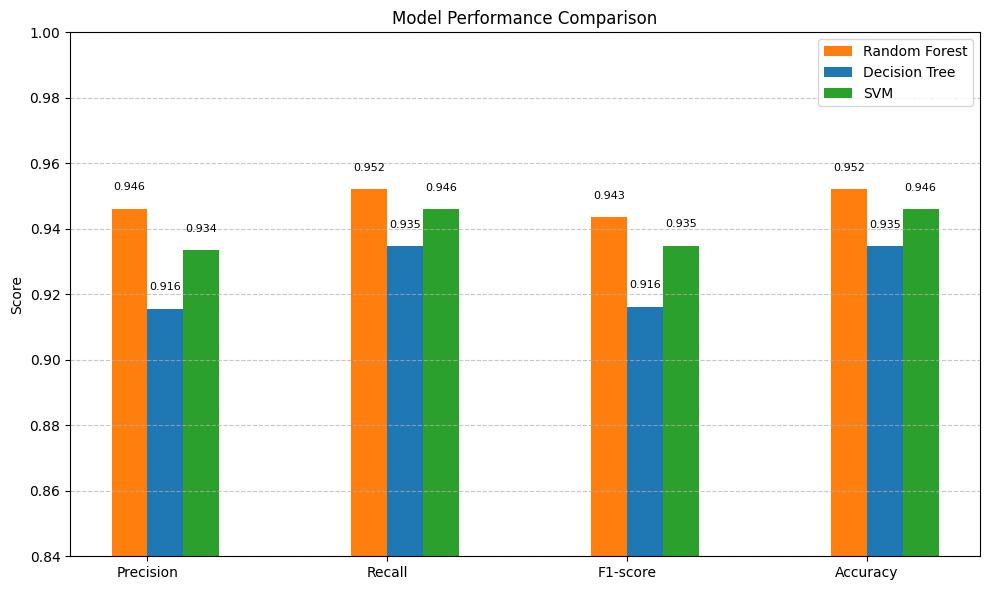

In [12]:
plt.figure(figsize=(10, 6))
# define the colors for the models: orange for SVM, blue for Random Forest, green for Decision Tree
colors = ['#ff7f0e', '#1f77b4', '#2ca02c']

# Get metrics for each model
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
x = np.arange(len(metrics))
width = 0.15  # Width of bars

# Plot bars for each model
for i, (model_name, model_results) in enumerate(results.items()):
    values = [
        model_results['Precision'],
        model_results['Recall'],
        model_results['F1'],
        model_results['Accuracy']
    ]
    plt.bar(x + i*width, values, width, label=model_name, color=colors[i])
    for j, v in enumerate(values):
        plt.text(x[j] + i*width, v + 0.005, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=8)
        
# Customize plot
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width/2, metrics)
plt.legend()

# Add grid
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to match your image
plt.ylim(0.84, 1.0)

plt.tight_layout()
plt.savefig('../data/eval_results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

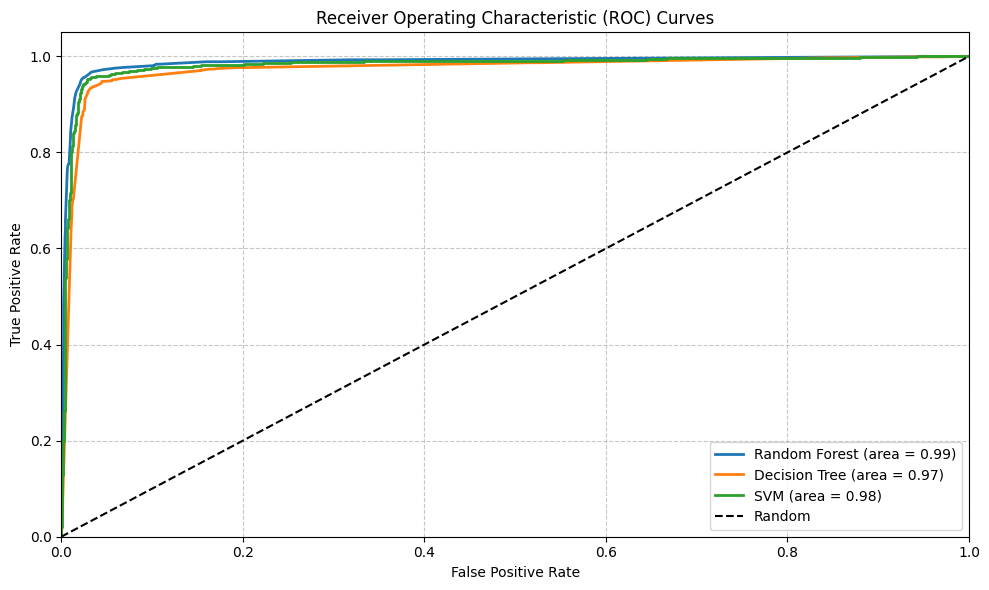


AUC-ROC Scores:
--------------------------------------------------
Random Forest: 0.988
Decision Tree: 0.974
SVM: 0.982


In [13]:
# Since we have multiclass classification, we need to binarize the labels
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Create figure for ROC curves
plt.figure(figsize=(10, 6))

# Plot ROC curves for each model
for name, model in models.items():
    y_score = model.predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot micro-average ROC curve
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'{name} (area = {roc_auc["micro"]:.2f})',
        linewidth=2,
    )

# Plot diagonal line (random classifier performance)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../data/eval_results/model_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# Print AUC-ROC scores for each model
print("\nAUC-ROC Scores:")
print("-" * 50)
for name, model in models.items():
    y_score = model.predict_proba(X_test)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr["micro"], tpr["micro"])
    print(f"{name}: {roc_auc:.3f}")